# Прогнозное Техническое Обслуживание (ТО)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install scikit-optimize

  Using cached scikit_optimize-0.10.1-py2.py3-none-any.whl (107 kB)
  Using cached pyaml-24.4.0-py3-none-any.whl (24 kB)


In [6]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost
import seaborn as sns

In [8]:
# загрузка данных
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
                'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
col_names = index_names + setting_names + sensor_names

train = pd.read_csv(('train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv(('test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(('RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

Набор данных включает симуляции нескольких турбодвигателей со временем, каждая строка содержит следующую информацию:
1. Номер двигателя
2. Время в циклах
3. Три рабочих настройки
4. 21 показании сенсоров

Описания сенсоров на английском:


| Name      |Description                      |Unit     |    
|-----------|---------------------------------|---------|    
| T2        | Total temperature at fan inlet  | °R      |    
| T24       | Total temperature at LPC outlet | °R      |    
| T30       | Total temperature at HPC outlet | °R      |    
| T50       | Total temperature at LPT outlet | °R      |    
| P2        | Pressure at fan inlet           | psia    |    
| P15       | Total pressure in bypass-duct   | psia    |    
| P30       | Total pressure at HPC outlet    | psia    |    
| Nf        | Physical fan speed              | rpm     |    
| Nc        | Physical core speed             | rpm     |    
| epr       | Engine pressure ratio (P50/P2)  | --      |    
| Ps30      | Static pressure at HPC outlet   | psia    |    
| phi       | Ratio of fuel flow to Ps30      | pps/psi |    
| NRf       | Corrected fan speed             | rpm     |    
| NRc       | Corrected core speed            | rpm     |    
| BPR       | Bypass Ratio                    | --      |    
| farB      | Burner fuel-air ratio           | --      |    
| htBleed   | Bleed Enthalpy                  | --      |    
| Nf_dmd    | Demanded fan speed              | rpm     |    
| PCNfR_dmd | Demanded corrected fan speed    | rpm     |    
| W31       | HPT coolant bleed               | lbm/s   |    
| W32       | LPT coolant bleed               | lbm/s   |    

### EDA

In [9]:
# Осмотр первых нескольких строк данных
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Используем функцию describe, чтобы увидеть, что мы можем узнать о количестве циклов, которые двигатели проходили в среднем перед поломкой.

In [10]:
train[index_names].describe()

,unit_nr,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [11]:
train[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


Набор данных содержит в общей сложности 20631 строк, номера двигателей начинаются с 1 и заканчиваются на 100. Двигатель, который сломался первым, сделал это после 128 циклов, в то время как двигатель, который работал дольше всего, сломался после 362 циклов. Средний двигатель ломается между 199 и 206 циклами, однако стандартное отклонение 46 циклов довольно велико.

In [12]:
train[setting_names].describe()

,setting_1,setting_2,setting_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


In [13]:
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
T2,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
T24,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
T30,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
T50,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
P2,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
P15,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
P30,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
Nf,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
Nc,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
epr,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


Просмотр стандартного отклонения показывает, что сенсоры T2, epr, Nf_dmd и PCNfR_dmd не имеют никакой флуктуации вообще, их можно безопасно исключить, так как они не содержат полезной информации. Просмотр квантилей показывает, что сенсоры P2, P15 и farB имеют небольшую флуктуацию и требуют дополнительной проверки. Сенсоры Nc и NRc имеют наибольшую флуктуацию, однако это не означает, что другие сенсоры не могут содержать ценную информацию.

In [14]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_nr,13096.0,51.543907,2.828942e+01,1.0000,28.0000,52.0000,76.0000,100.0000
time_cycles,13096.0,76.836515,5.305775e+01,1.0000,33.0000,69.0000,113.0000,303.0000
setting_1,13096.0,-0.000011,2.202685e-03,-0.0082,-0.0015,-0.0000,0.0015,0.0078
setting_2,13096.0,0.000004,2.940306e-04,-0.0006,-0.0002,-0.0000,0.0003,0.0007
setting_3,13096.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
T2,13096.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
T24,13096.0,642.475088,4.008993e-01,641.1300,642.1975,642.4600,642.7400,644.3000
T30,13096.0,1588.099204,5.003274e+00,1569.0400,1584.6000,1587.9900,1591.3625,1607.5500
T50,13096.0,1404.735362,6.688309e+00,1384.3900,1399.9500,1404.4400,1409.0500,1433.3600
P2,13096.0,14.620000,1.776425e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [15]:
test[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,100.000000
mean,130.960000
std,53.593479
min,31.000000
25%,88.750000
50%,133.500000
75%,164.250000
max,303.000000


In [16]:
y_test.describe()

,RUL
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


Выше видно, что значения RUL для тестового набора данных предоставляются только для последнего цикла работы каждого двигателя

#### Вычисляем Оставшееся время до отказа оборудования - RUL

In [17]:
def add_remaining_useful_life(df):
    # Получить общее количество циклов для каждого устройства
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Объединить максимальное количество циклов обратно в оригинальный DataFrame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Рассчитать оставшийся полезный срок службы для каждой строки
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # Удалить max_cycle, так как он больше не нужен
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names + ['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


#### Строим графики

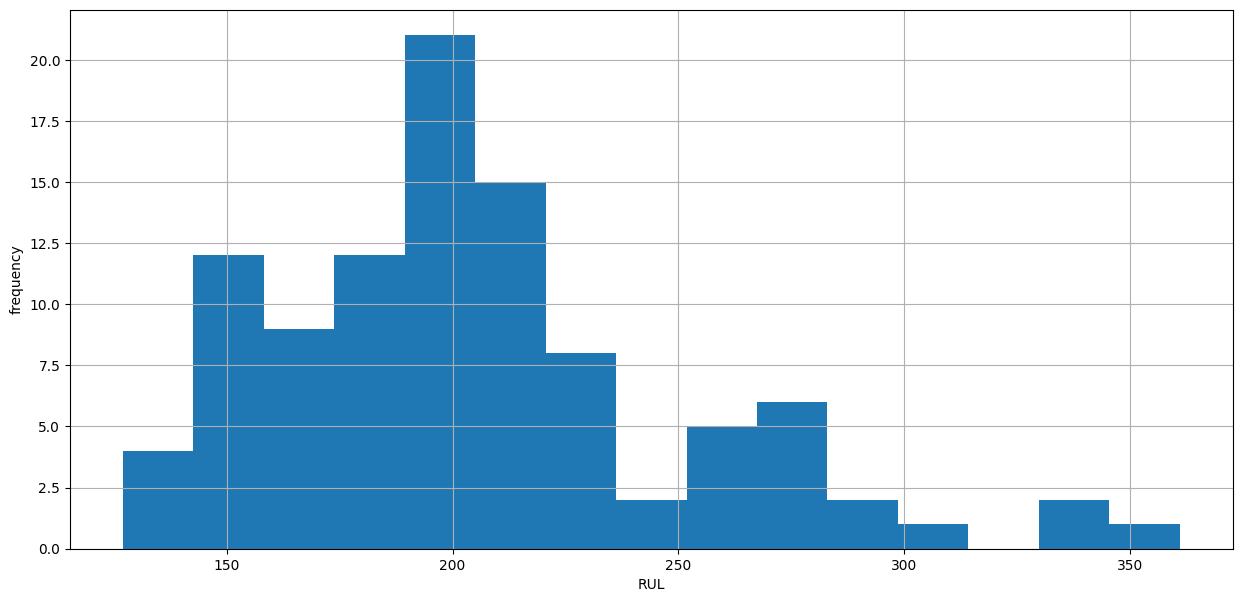

In [18]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

Гистограмма подтверждает, что большинство двигателей выходят из строя примерно через 200 циклов. Кроме того, распределение смещено вправо, с небольшим количеством двигателей, прослуживших более 300 циклов.

In [19]:
def plot_sensor(ax, sensor_name):
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # отображать только каждое 10-е устройство
            ax.plot('RUL', sensor_name, data=train[train['unit_nr'] == i])
    ax.set_xlim(250, 0)  # инвертировать ось x, чтобы RUL уменьшался до нуля
    ax.set_xticks(np.arange(0, 275, 25))
    ax.set_ylabel(sensor_name)
    ax.set_xlabel('Remaining Useful Life')

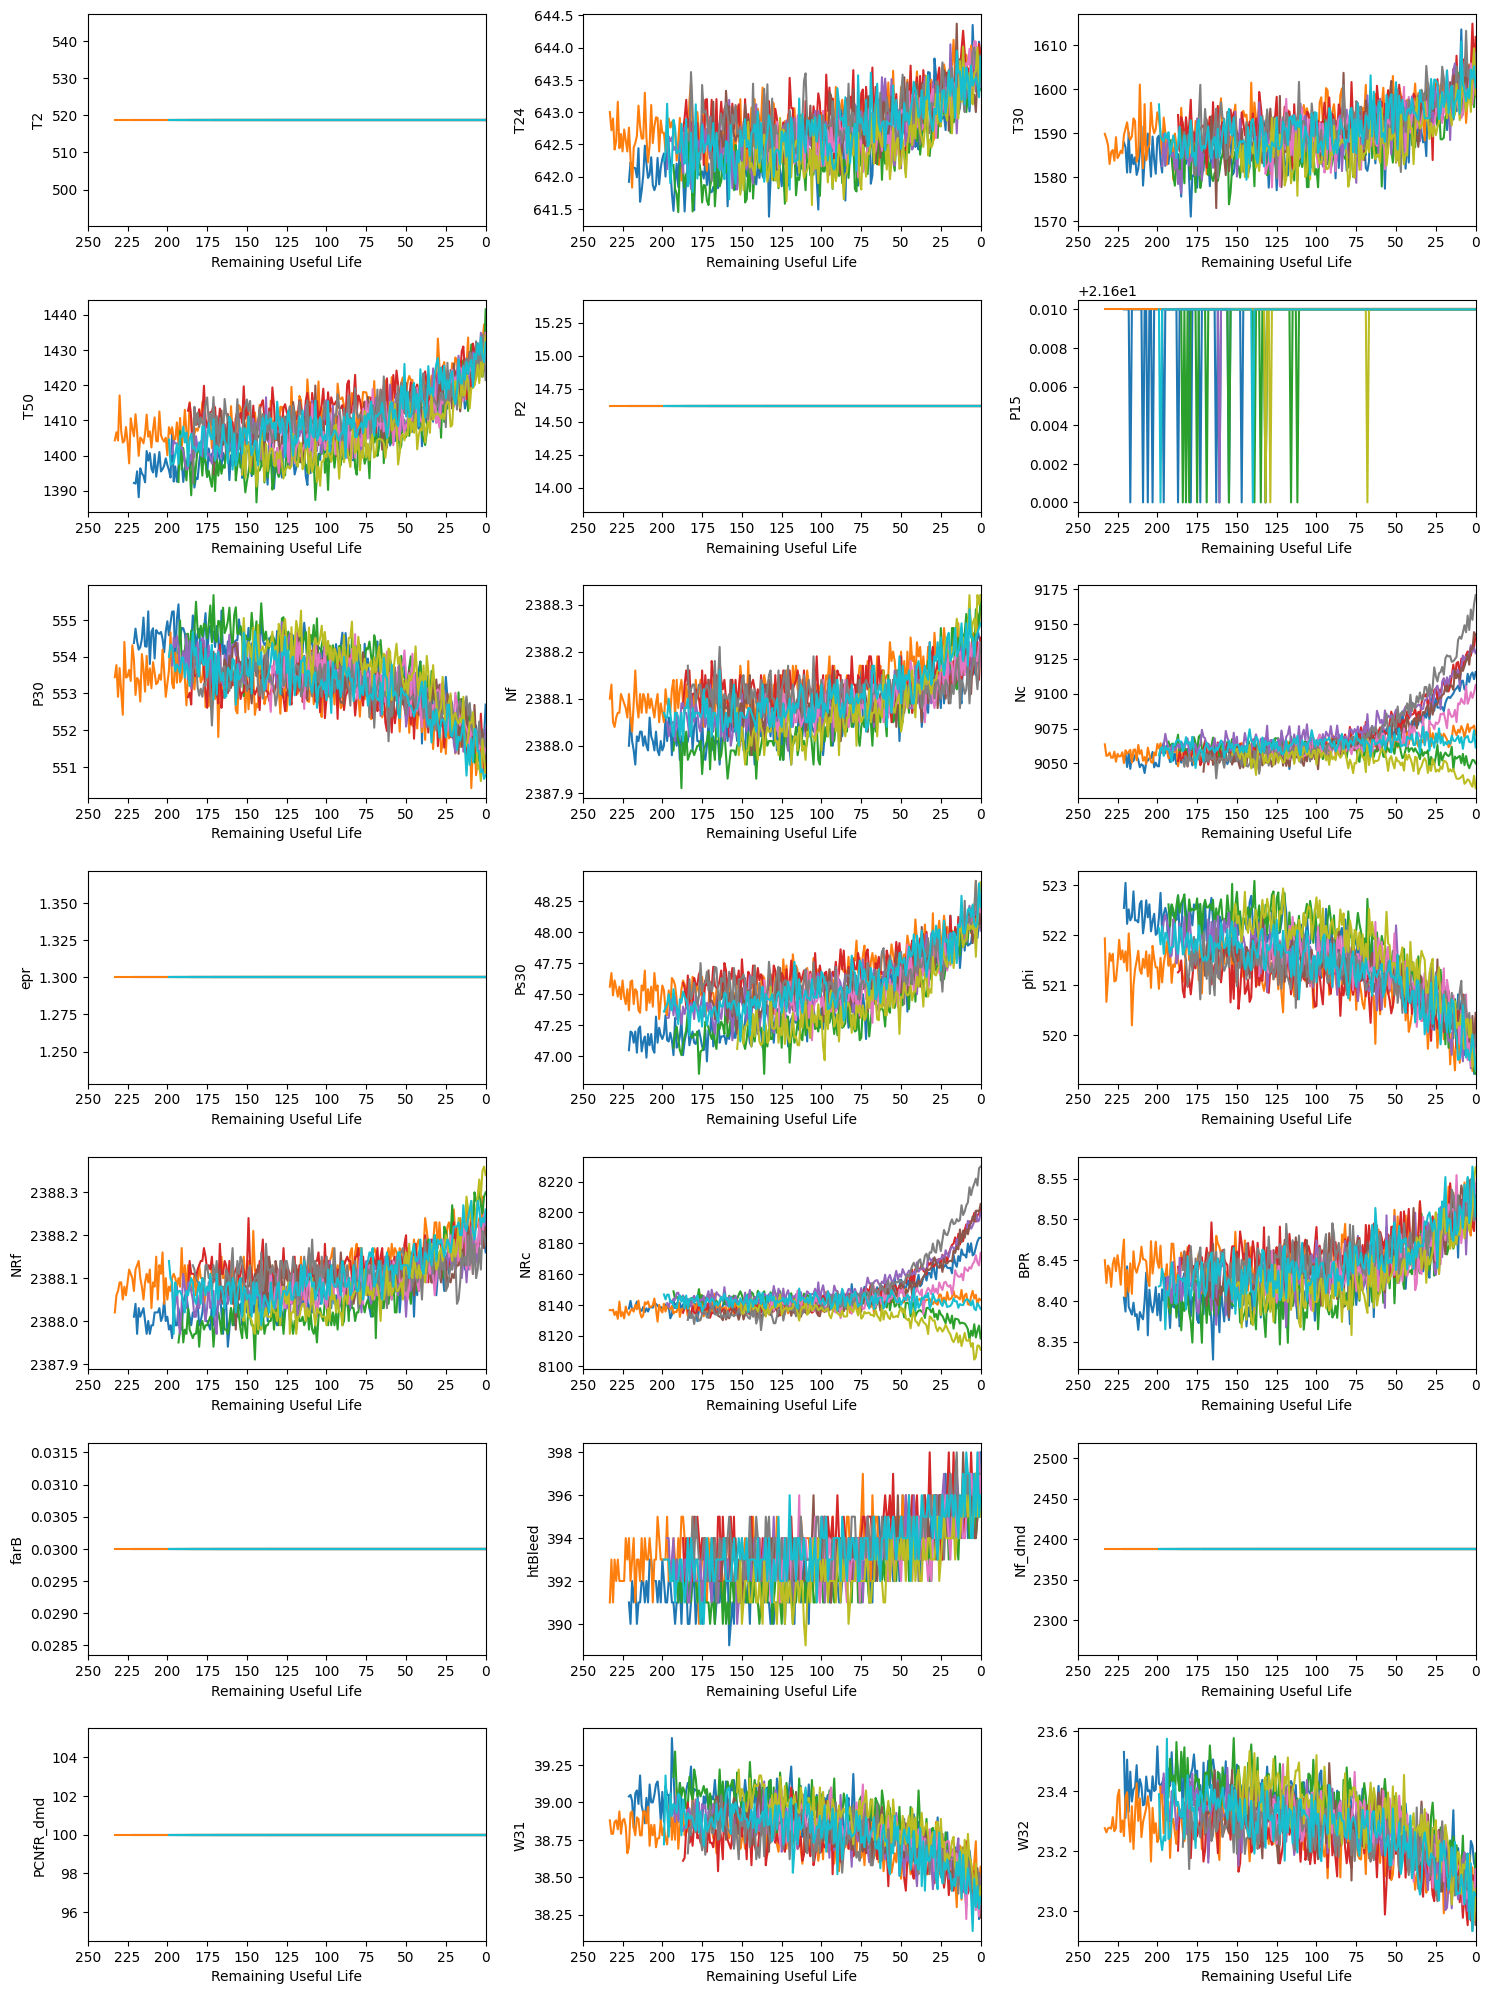

In [20]:
# Создание фигуры и сетки подграфиков размером 3x7
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))
axes = axes.flatten()  # Преобразовать 2D массив осей в 1D для удобства итерации

# Построение графика для каждого сенсора на соответствующем подграфике
for i, sensor_name in enumerate(sensor_names):
    plot_sensor(axes[i], sensor_name)

# Настройка расположения подграфиков
plt.tight_layout()
plt.show()

Графики сенсоров позволяют нам понять их взаимосвязь с убывающим RUL. Мы видим, что некоторые сенсоры имеют четкие тренды относительно RUL, в то время как другие остаются стабильными или имеют непредсказуемое поведение. На основе нашего анализа данных мы определяем, что значения некоторых сенсоров остаются постоянными во времени и они мало влияют на RUL.

#### Извлечение значимых признаков, которые сильно влияют на RUL

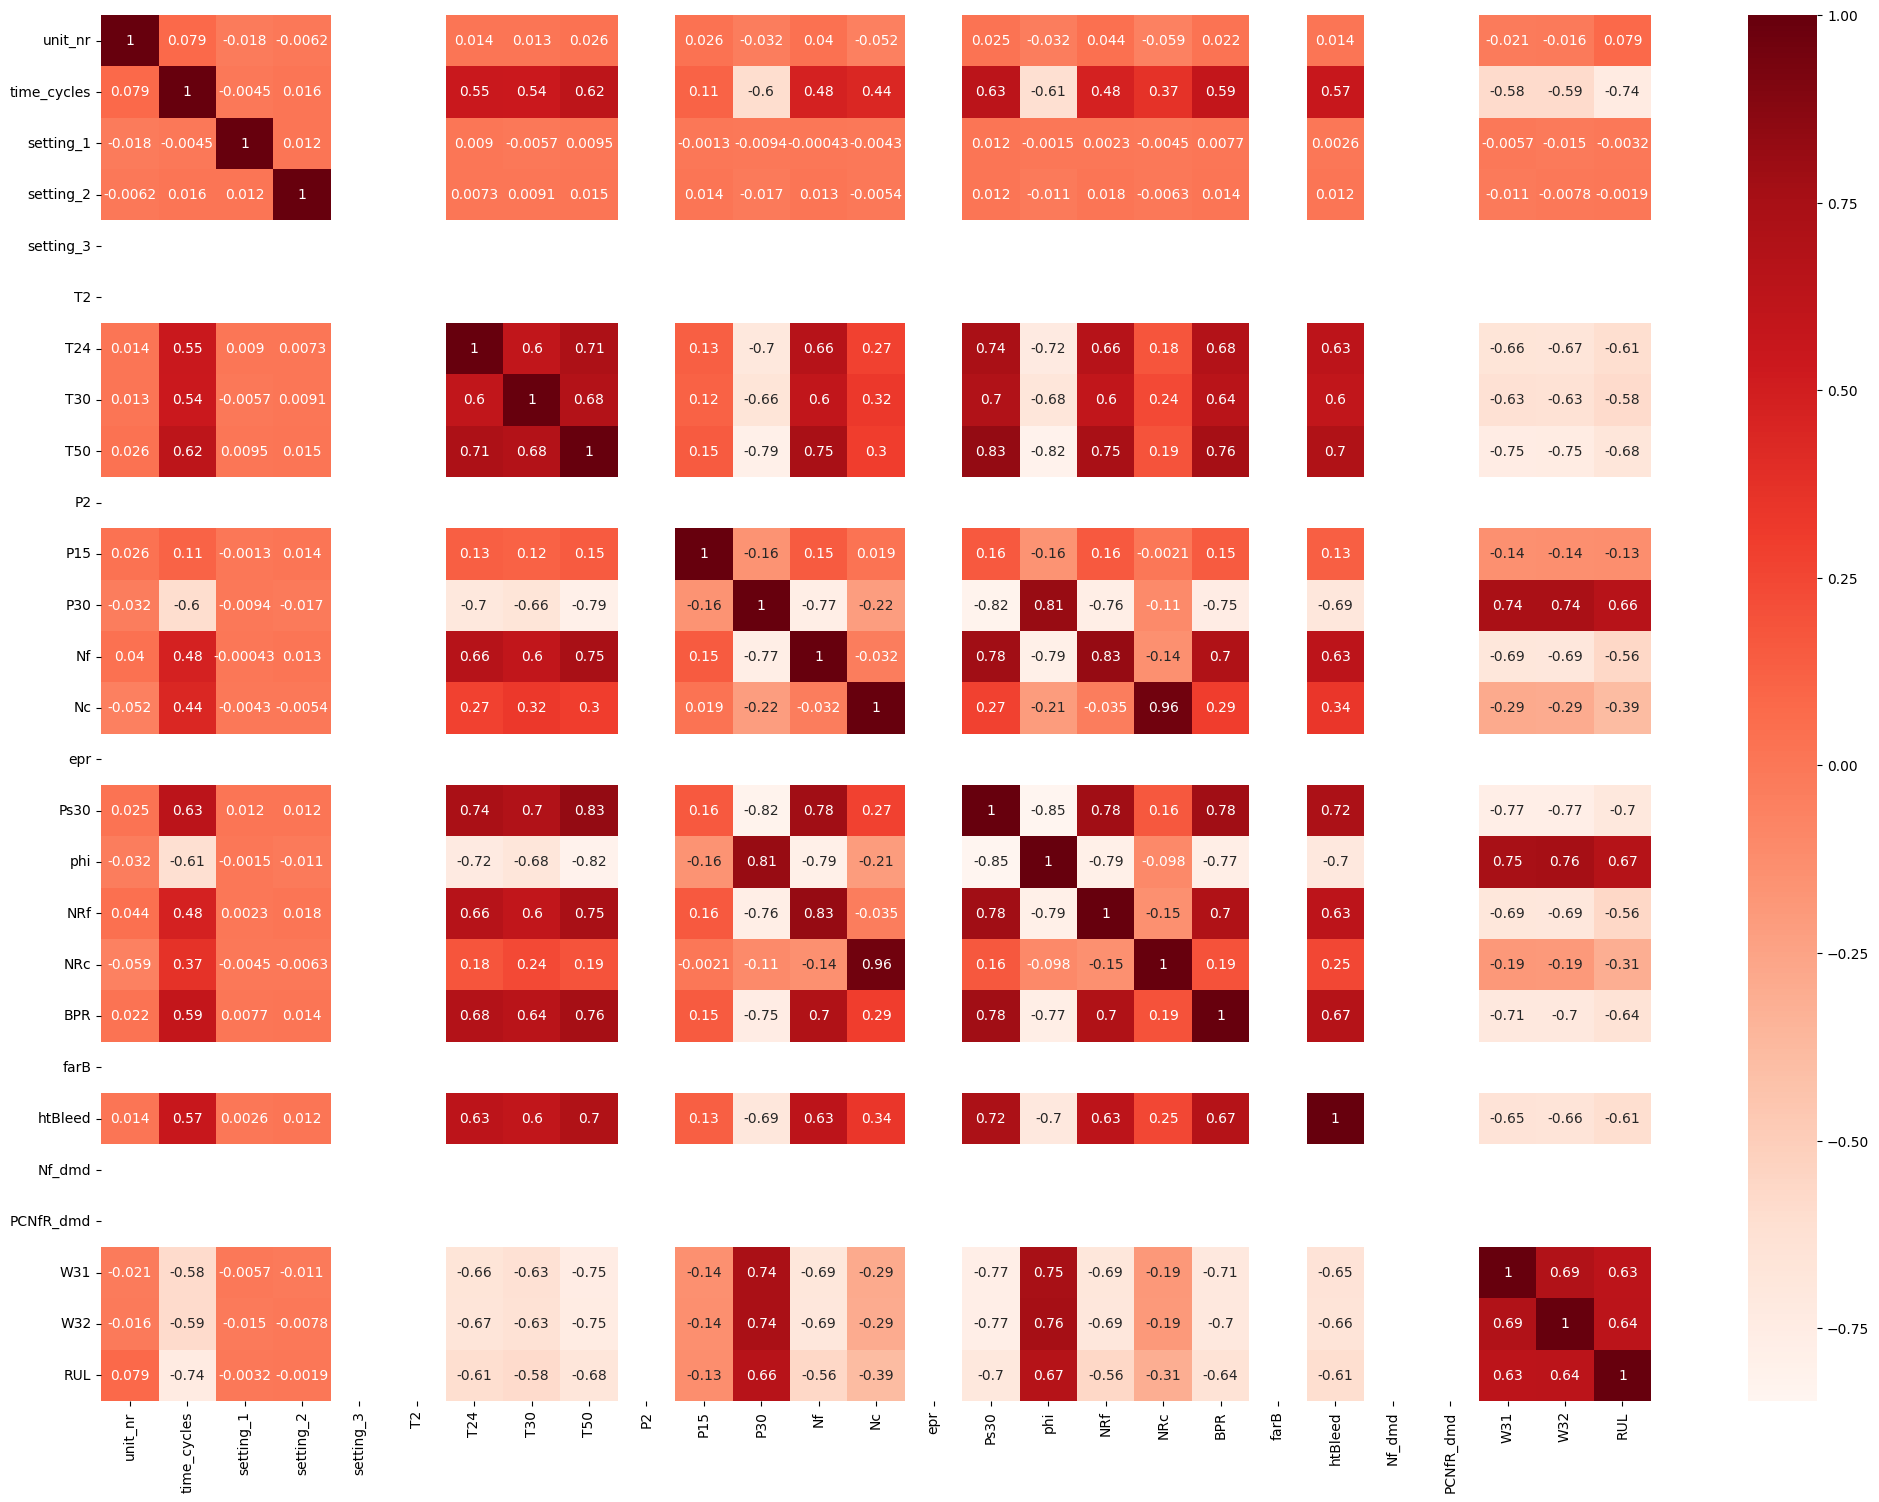

In [21]:
plt.figure(figsize=(25,18))
sns.heatmap(train.corr(),annot=True ,cmap='Reds')
plt.show()

In [22]:
# Вычисление корреляционной матрицы для всех признаков
cor = train.corr()

# Выбор признаков, которые имеют абсолютное значение корреляции с RUL >= 0.5
train_relevant_features = cor.loc[abs(cor['RUL']) >= 0.3, 'RUL']

# Отображение релевантных признаков
print(train_relevant_features)

time_cycles   -0.736241
T24           -0.606484
T30           -0.584520
T50           -0.678948
P30            0.657223
Nf            -0.563968
Nc            -0.390102
Ps30          -0.696228
phi            0.671983
NRf           -0.562569
NRc           -0.306769
BPR           -0.642667
htBleed       -0.606154
W31            0.629428
W32            0.635662
RUL            1.000000
Name: RUL, dtype: float64


In [23]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[1:]
list_relevant_features

Index(['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc',
       'BPR', 'htBleed', 'W31', 'W32', 'RUL'],
      dtype='object')

В приведённом выше списке содержатся значимые признаки, которые имеют корреляцию по модулю больше или равную 0.3 с нашей целевой переменной RUL. Мы оставим только эти признаки в качестве предикторов.

In [24]:
X_train = train[list_relevant_features]
y_train = X_train.pop('RUL')

# Поскольку истинные значения RUL для тестового набора данных предоставляются только для последнего цикла работы каждого двигателя,
# тестовый набор данных также разбивается для представления только последнего цикла работы.
X_test = test.groupby('unit_nr').last().reset_index()[X_train.columns]

In [25]:
# Функция для оценки модели
def evaluate(y_true, y_pred, label='test'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_pred)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse, variance;

### Базовая модель

In [26]:
## Линейная регрессия
# Обучаем модель
lm = LinearRegression()
lm.fit(X_train, y_train)

# Прогноз и оценка
y_pred_train = lm.predict(X_train)
RMSE_train, R2_train = evaluate(y_train, y_pred_train, 'train')

y_pred_test = lm.predict(X_test)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)

train set RMSE:44.66819159545438, R2:0.5794486527796744
test set RMSE:31.952633027730382, R2:0.40877368076616405


In [27]:
# Dataframe, который будет содержать результаты всех примененных моделей
Results=pd.DataFrame({'Model':['LR'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]})
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,44.668192,0.579449,31.952633,0.408774


In [28]:
def plot_results(y_true, y_pred):
    width = 0.8

    actuals = [int(x) for x in y_true.values]
    predictions = list(y_pred)

    indices = np.arange(len(y_pred))

    plt.figure(figsize=(60,20))

    plt.bar(indices, actuals, width=width,
            color='b', label='Actual RUL')
    plt.bar([i for i in indices], predictions,
            width=0.5*width, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 30})
    plt.tick_params(labelsize=30)

    plt.show()

<ipython-input-28-12397b96eb18>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actuals = [int(x) for x in y_true.values]


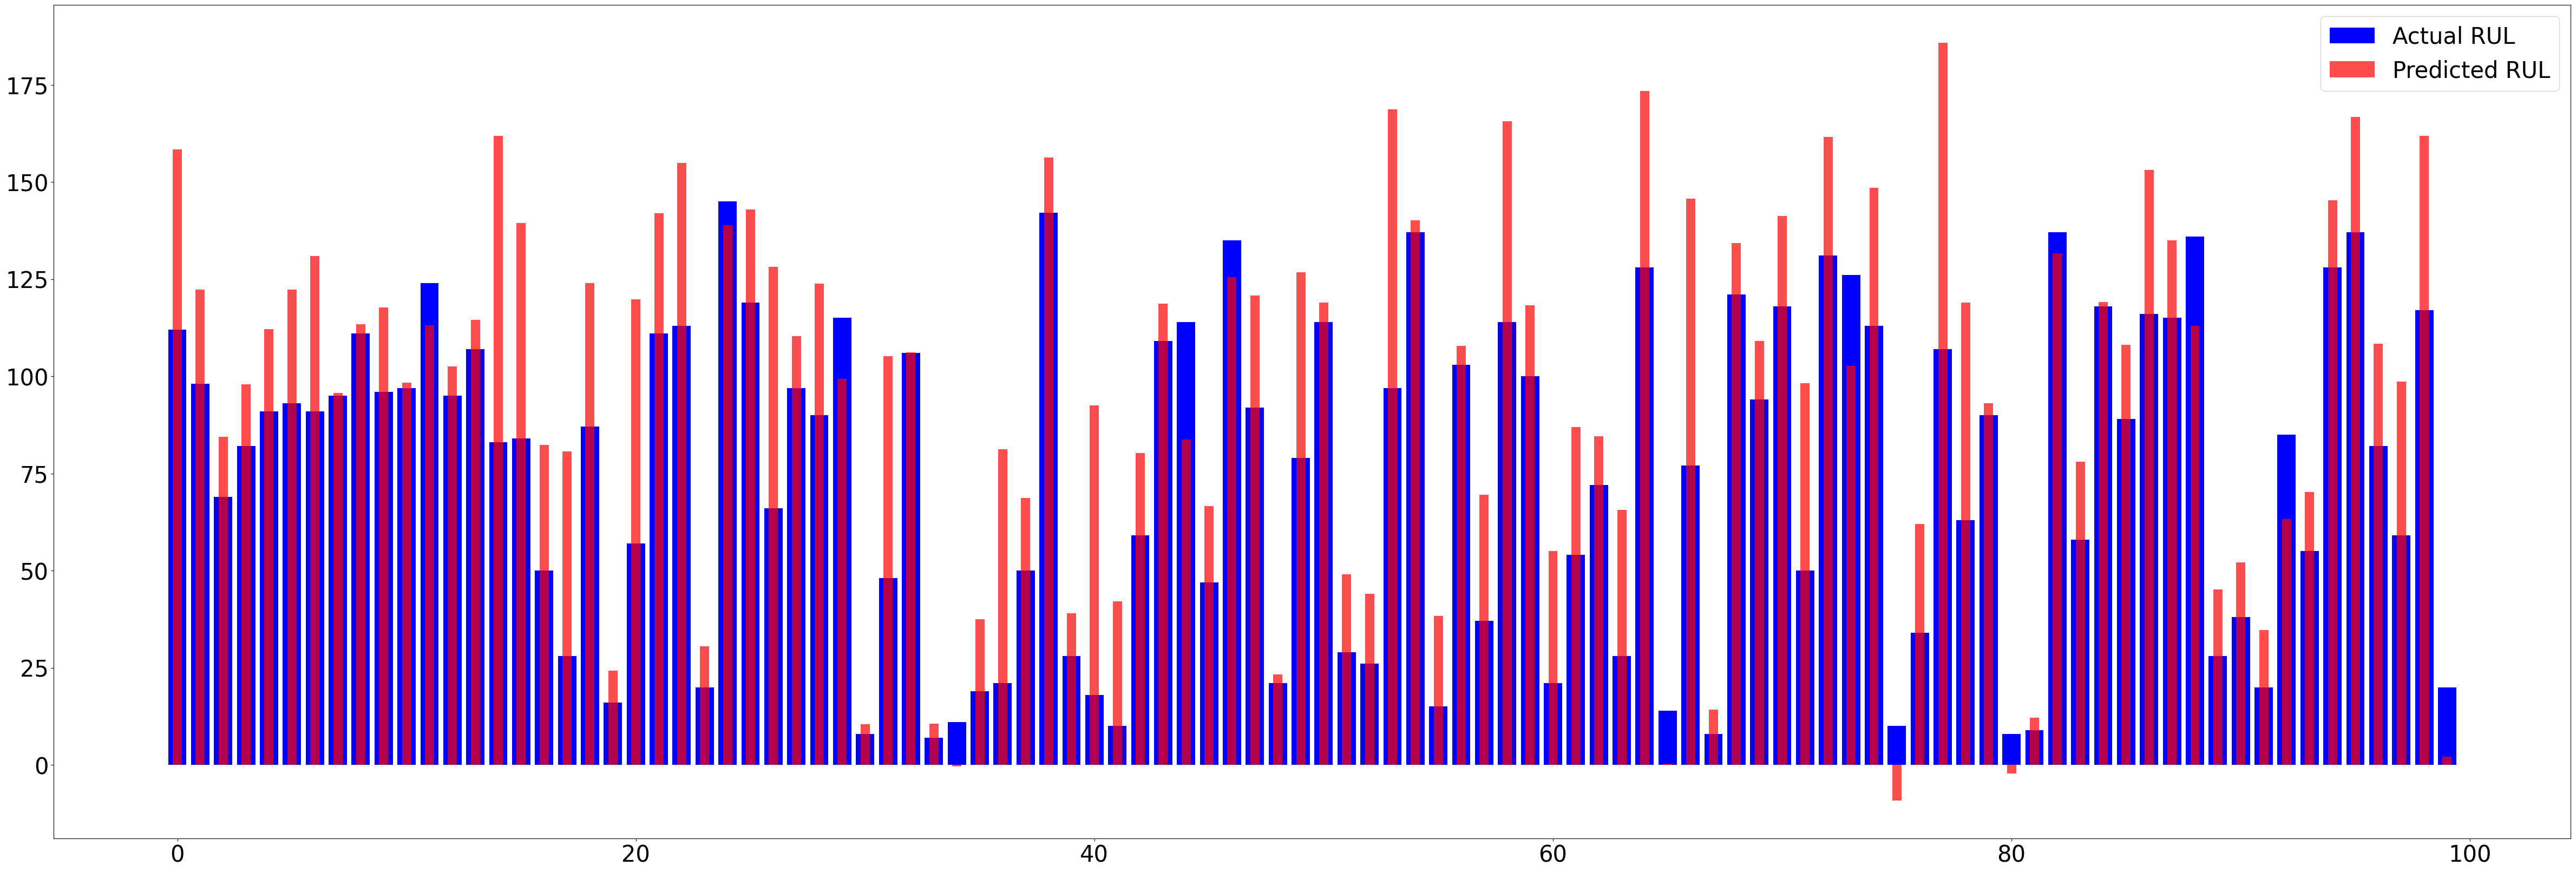

In [29]:
plot_results(y_test,y_pred_test)

### Пересмотр RUL

Наше текущее предположение о RUL для обучающего набора данных состоит в том, что он линейно убывает до нуля. Однако, когда мы анализируем сигналы датчиков, они часто показывают "изгиб" в своей кривой, указывающий на начало деградации. Исходя из предоставленной нам информации, мы не можем сказать ничего о RUL до этой точки, так как у нас нет никакой информации о начальном износе двигателей.
Поэтому мы предполагаем, что RUL вначале остается постоянным и начинает линейно убывать только после некоторого времени. Целью является получение аналогичного "изгиба" на кривой (см. изображение ниже).
Начальное постоянство RUL достигает двух целей:

1. Вначале постоянное RUL коррелирует лучше со стабильным средним сигналом датчика.
2. Более низкие пиковые значения RUL приводят к более низкому разбросу нашей целевой переменной, что упрощает подгонку линии.

In [30]:
clipped_rul = train.loc[train['unit_nr']==20].copy()
clipped_rul['RUL'].clip(upper=125, inplace=True)

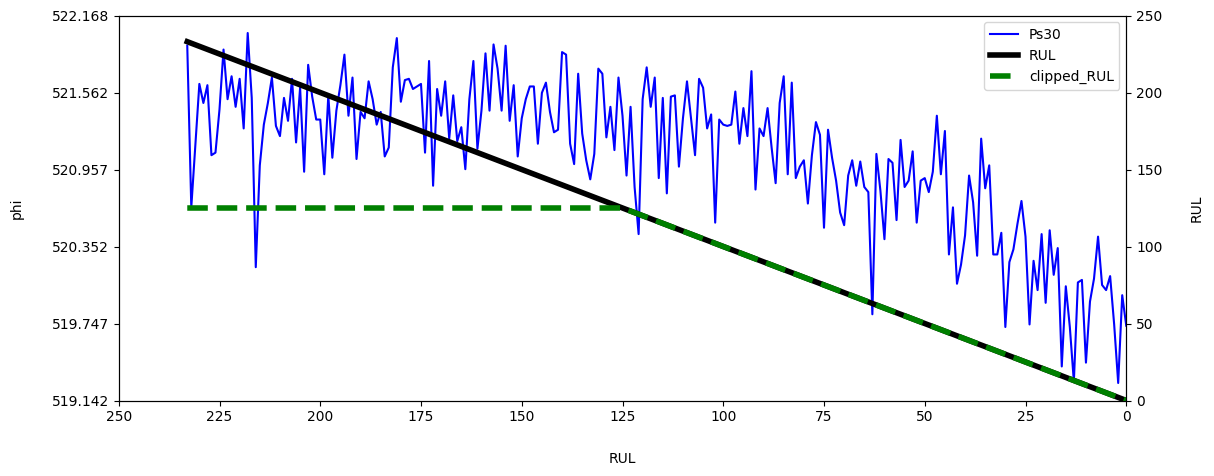

In [31]:
# Строим график для пересмотра RUL
fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

# График данных от сенсора
train_unit_20 = train.loc[train['unit_nr'] == 20]
signal = ax1.plot('RUL', 'phi', 'b', data=train_unit_20)
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=4, data=train_unit_20)
rul = train_unit_20['RUL']
rul_line2 = ax2.plot(rul, np.clip(rul, None, 125), '--g', linewidth=4, label='clipped_rul')

# Метки и пределы
ax1.set_xlim(250, 0)
ax1.set_xticks(np.arange(0, 275, 25))
ax1.set_ylabel('phi', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)
ax2.set_ylabel('RUL', labelpad=20)
ax2.set_ylim(0, 250)
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))
ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))

# Легенда
lines = signal + rul_line + rul_line2
labels = ['phi', 'RUL', 'clipped_RUL']
ax1.legend(lines, labels, loc=0)

plt.show()


In [32]:
y_train_clipped = y_train.clip(upper=125)

In [33]:
## Обрезанный RUL
# Обучаем модель
lm_cl = LinearRegression()
lm_cl.fit(X_train, y_train_clipped)

# Прогноз и оценка
y_pred_train = lm_cl.predict(X_train)
RMSE_train, R2_train = evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = lm_cl.predict(X_test)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)

train set RMSE:21.491018701515106, R2:0.7340432868050524
test set RMSE:21.90021340689146, R2:0.7222608196546001


In [34]:
# Dataframe, который будет содержать результаты всех примененных моделей
Results=pd.concat([Results, pd.DataFrame({'Model':['LR_Clipped'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]})], ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,44.668192,0.579449,31.952633,0.408774
1,LR_Clipped,21.491019,0.734043,21.900213,0.722261


RMSE для обучающего набора данных уменьшился более чем вдвое. Это показывает, насколько сильное влияние оказывали высокие 'предполагаемые' значения RUL на общую производительность модели. Однако гораздо важнее улучшение на тестовом наборе данных (почти на треть!). Это информирует нас о том, что обновленная гипотеза полезна для прогнозирования RUL. В моделях далее мы будем ее использовать

<ipython-input-28-12397b96eb18>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actuals = [int(x) for x in y_true.values]


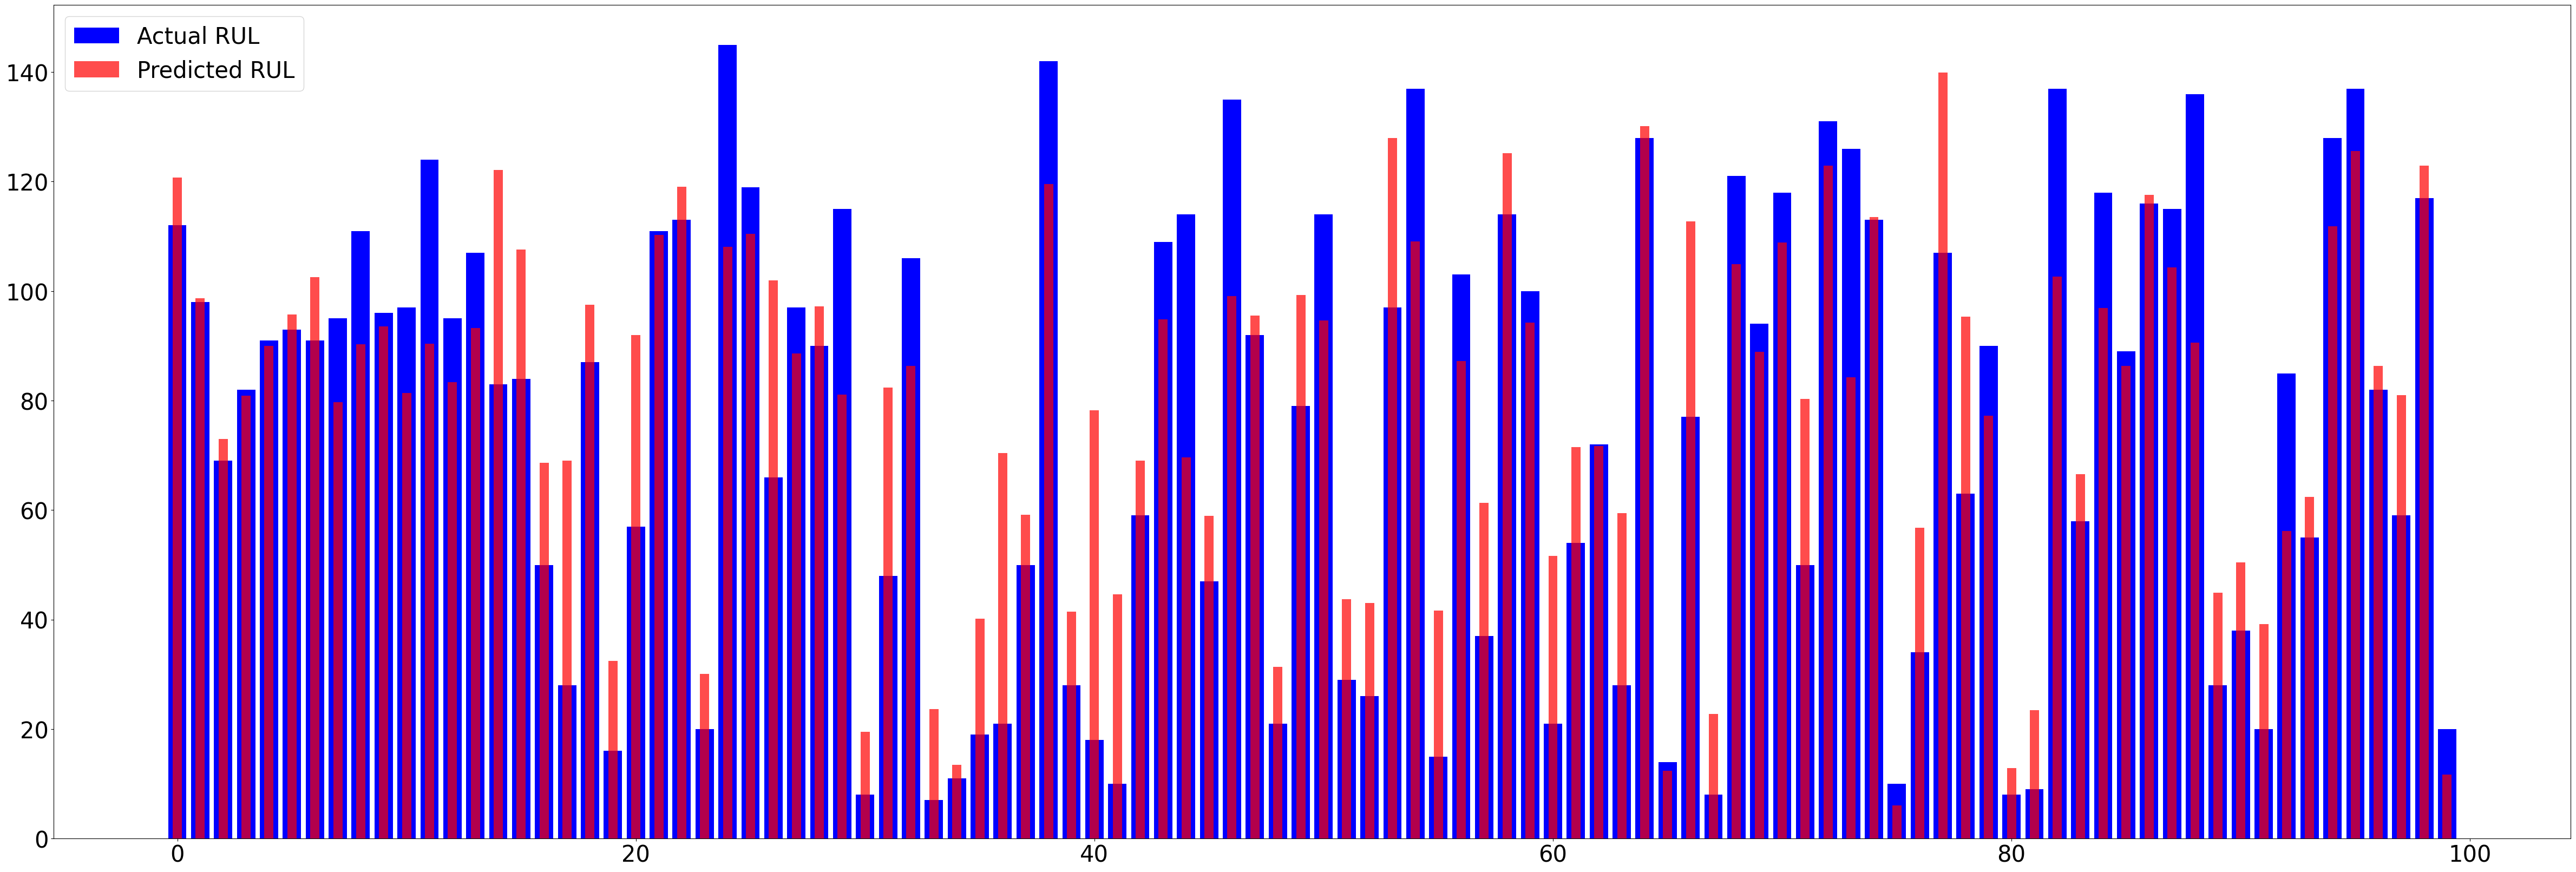

In [35]:
plot_results(y_test,y_pred_test)

### SVR

In [36]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [37]:
## SVM - Метод опорных векторов
# Обучаем модель
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train_clipped)

# Прогноз и оценка
y_pred_train = svr.predict(X_train_scaled)
RMSE_train, R2_train = evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = svr.predict(X_test_scaled)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)

train set RMSE:18.597971321286852, R2:0.8008280844243122
test set RMSE:19.25359915682962, R2:0.7853334840732211


In [38]:
# Dataframe, который будет содержать результаты всех примененных моделей
Results=pd.concat([Results, pd.DataFrame({'Model':['SVR'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]})], ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,44.668192,0.579449,31.952633,0.408774
1,LR_Clipped,21.491019,0.734043,21.900213,0.722261
2,SVR,18.597971,0.800828,19.253599,0.785333


Мы видим, что RMSE для тестовой и обучающей модели улучшилось после применения модели SVM.

<ipython-input-28-12397b96eb18>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actuals = [int(x) for x in y_true.values]


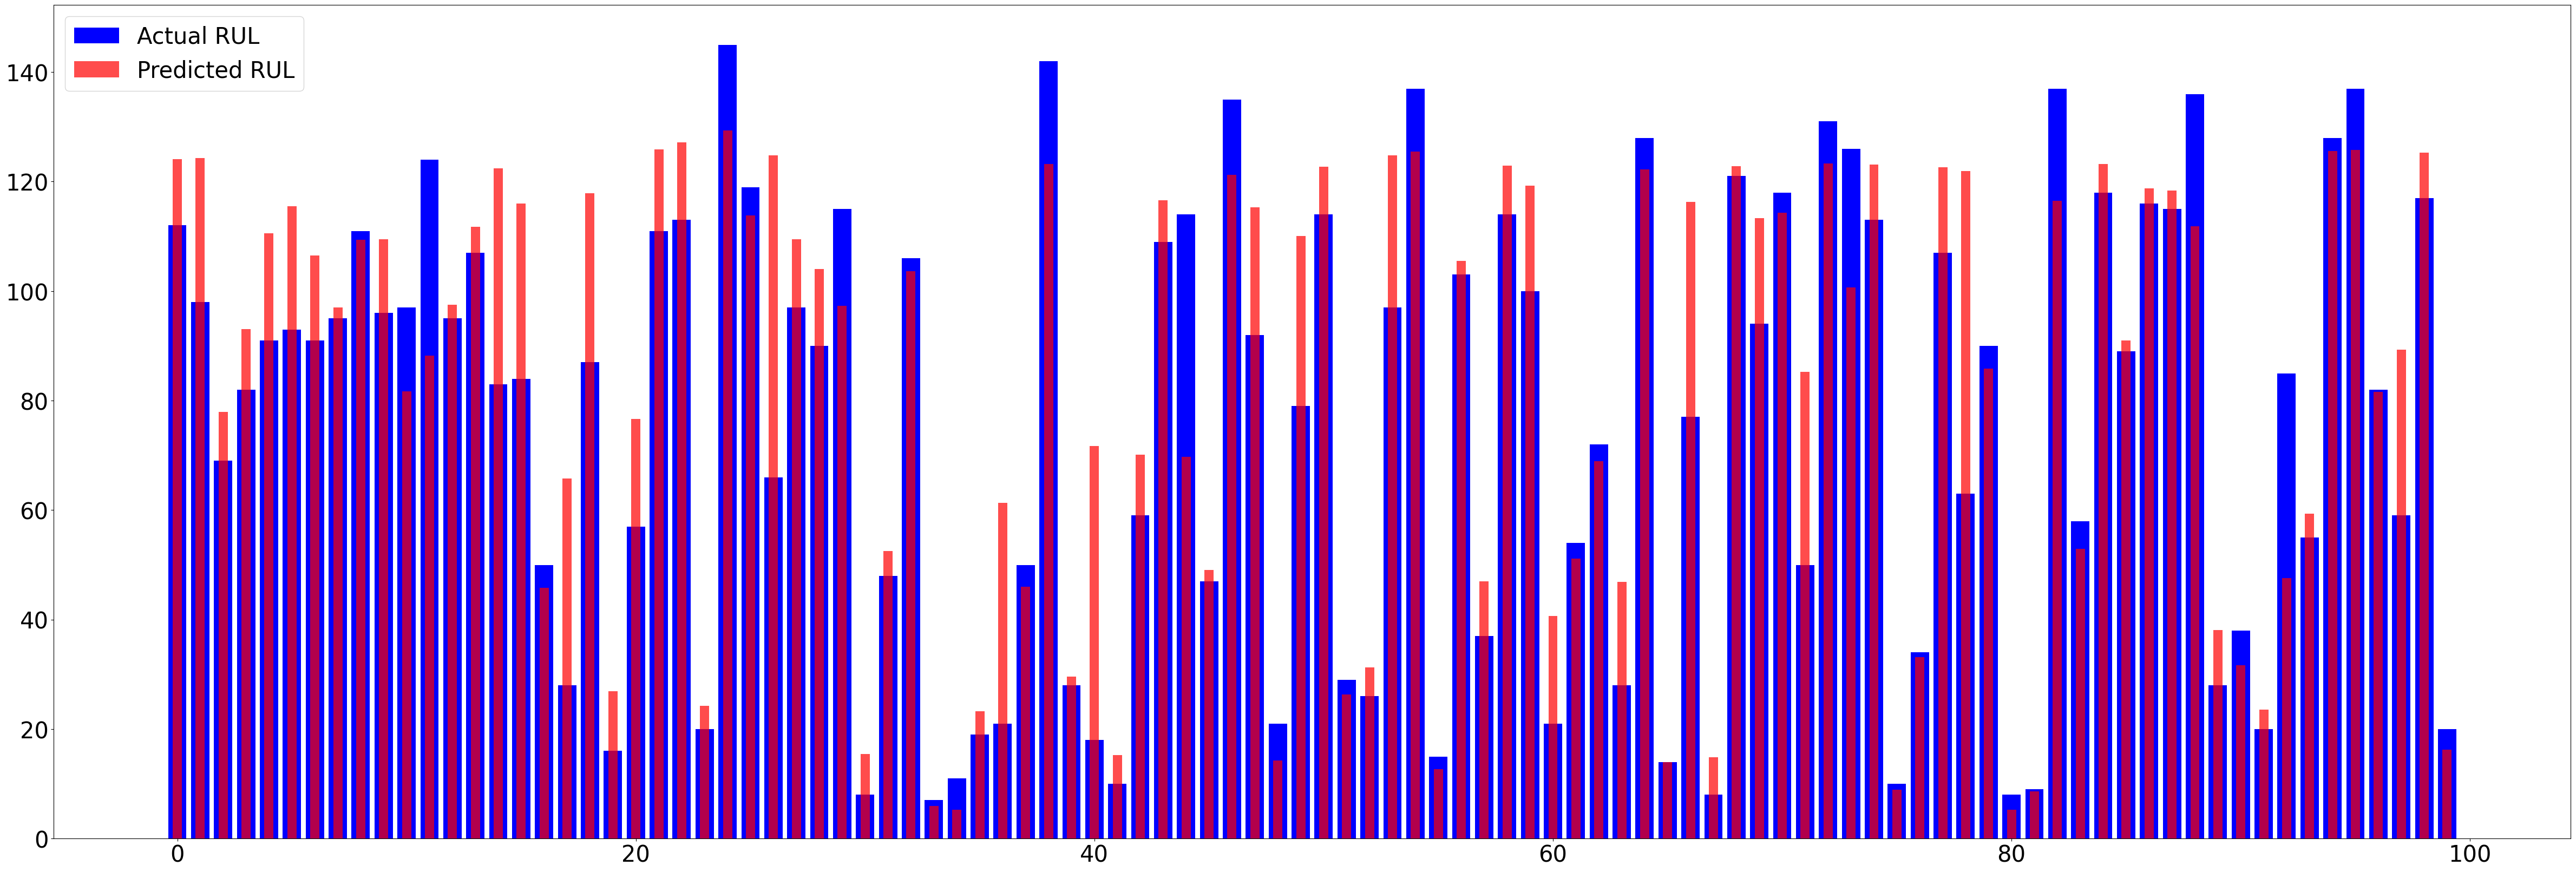

In [39]:
plot_results(y_test,y_pred_test)

### Random Forest

In [40]:
## Random Forest
# Обучаем модель
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
rf.fit(X_train_scaled, y_train_clipped)

# Прогноз и оценка
y_pred_train = rf.predict(X_train_scaled)
RMSE_train, R2_train = evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = rf.predict(X_test_scaled)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)

train set RMSE:6.7639881572043175, R2:0.9736547314431163
test set RMSE:17.882269319076926, R2:0.8148235651377498


In [41]:
# Dataframe, который будет содержать результаты всех примененных моделей
Results=pd.concat([Results, pd.DataFrame({'Model':['RF'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]})], ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,44.668192,0.579449,31.952633,0.408774
1,LR_Clipped,21.491019,0.734043,21.900213,0.722261
2,SVR,18.597971,0.800828,19.253599,0.785333
3,RF,6.763988,0.973655,17.882269,0.814824


RMSE на обучающем наборе данных значительно уменьшилась, но на тестовом наборе она уменьшилась не так сильно. Это может указывать на то, что наша модель переобучена, что означает, что модель очень точна на обучающем наборе данных, но неточна на тестовом наборе.

<ipython-input-28-12397b96eb18>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actuals = [int(x) for x in y_true.values]


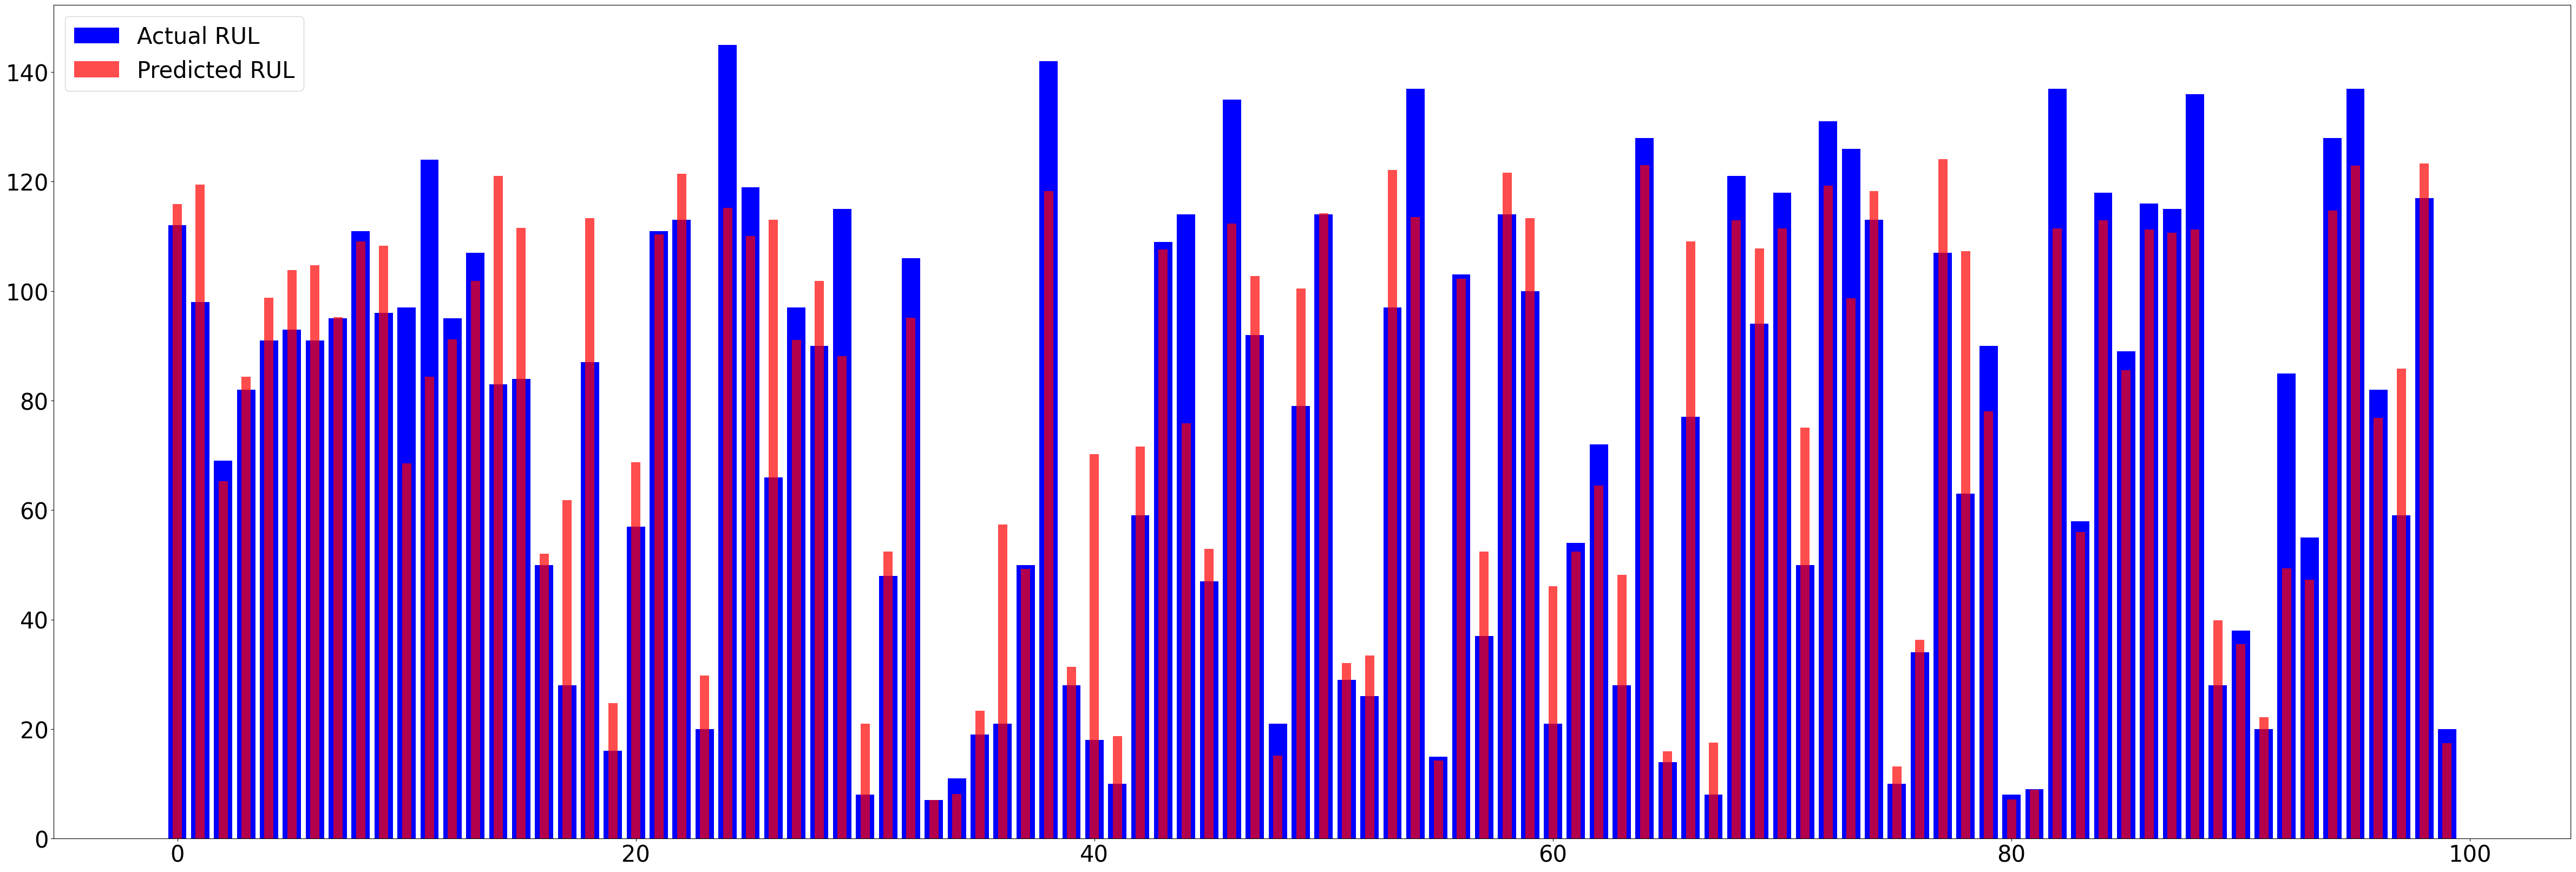

In [42]:
plot_results(y_test,y_pred_test)

In [51]:
# Определение пространства поиска параметров
param_space = {
    'n_estimators': Integer(10, 100),
    'max_depth': Integer(1, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10)
}

# Создание регрессора случайного леса
rf = RandomForestRegressor(random_state=42)

# Создание экземпляра поиска оптимальных параметров методом байесовской оптимизации
bayes_search = BayesSearchCV(estimator=rf, search_spaces=param_space, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Выполнение байесовской оптимизации
bayes_search.fit(X_train_scaled, y_train_clipped)

# Получение лучших параметров
best_params = bayes_search.best_params_
print("Лучшие параметры:", best_params)

# Использование лучшей модели
best_rf = bayes_search.best_estimator_

# Прогнозирование и оценка
y_pred_train = best_rf.predict(X_train_scaled)
RMSE_train, R2_train = evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = best_rf.predict(X_test_scaled)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)



Лучшие параметры: OrderedDict([('max_depth', 13), ('min_samples_leaf', 9), ('min_samples_split', 2), ('n_estimators', 100)])
train set RMSE:14.632206187975186, R2:0.8767132007697016
test set RMSE:18.273063385209998, R2:0.8066415405772953


In [54]:
## Random Forest tuned
# Обучаем модель
rf_tuned = RandomForestRegressor(n_estimators=100, max_depth=13, min_samples_leaf=9, min_samples_split=2, max_features="sqrt", random_state=42)
rf_tuned.fit(X_train_scaled, y_train_clipped)

# Прогноз и оценка
y_pred_train = rf_tuned.predict(X_train_scaled)
RMSE_train, R2_train = evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = rf_tuned.predict(X_test_scaled)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)

train set RMSE:15.426868256446276, R2:0.8629583766881451
test set RMSE:17.846902109894394, R2:0.8155553175988777


In [55]:
Results=pd.concat([Results, pd.DataFrame({'Model':['RF_Tuned'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]})], ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,44.668192,0.579449,31.952633,0.408774
1,LR_Clipped,21.491019,0.734043,21.900213,0.722261
2,SVR,18.597971,0.800828,19.253599,0.785333
3,RF,6.763988,0.973655,17.882269,0.814824
4,XGB,16.990404,0.833772,18.417692,0.803569
5,RF_Tuned,15.426868,0.862958,17.846902,0.815555


После настройки гиперпараметров, избавились от переобучения модели.

### XGBoost

In [43]:
## XGBoost
# Обучаем модель
xgb = xgboost.XGBRegressor(n_estimators = 10, seed = 123)
xgb.fit(X_train_scaled, y_train_clipped)

# Прогноз и оценка
y_pred_train = xgb.predict(X_train_scaled)
RMSE_train, R2_train = evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = xgb.predict(X_test_scaled)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)

train set RMSE:16.990403786135037, R2:0.8337719334819317
test set RMSE:18.41769172822364, R2:0.8035686257978728


In [44]:
# Dataframe, который будет содержать результаты всех примененных моделей
Results=pd.concat([Results, pd.DataFrame({'Model':['XGB'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]})], ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,44.668192,0.579449,31.952633,0.408774
1,LR_Clipped,21.491019,0.734043,21.900213,0.722261
2,SVR,18.597971,0.800828,19.253599,0.785333
3,RF,6.763988,0.973655,17.882269,0.814824
4,XGB,16.990404,0.833772,18.417692,0.803569


Хоть производительность модели ухудшилась по сравнению с Random Forest, уменьшилась переобученность на обучающих данных. Мы можем попробовать настроить параметры так, чтобы повысить производительность.

<ipython-input-28-12397b96eb18>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actuals = [int(x) for x in y_true.values]


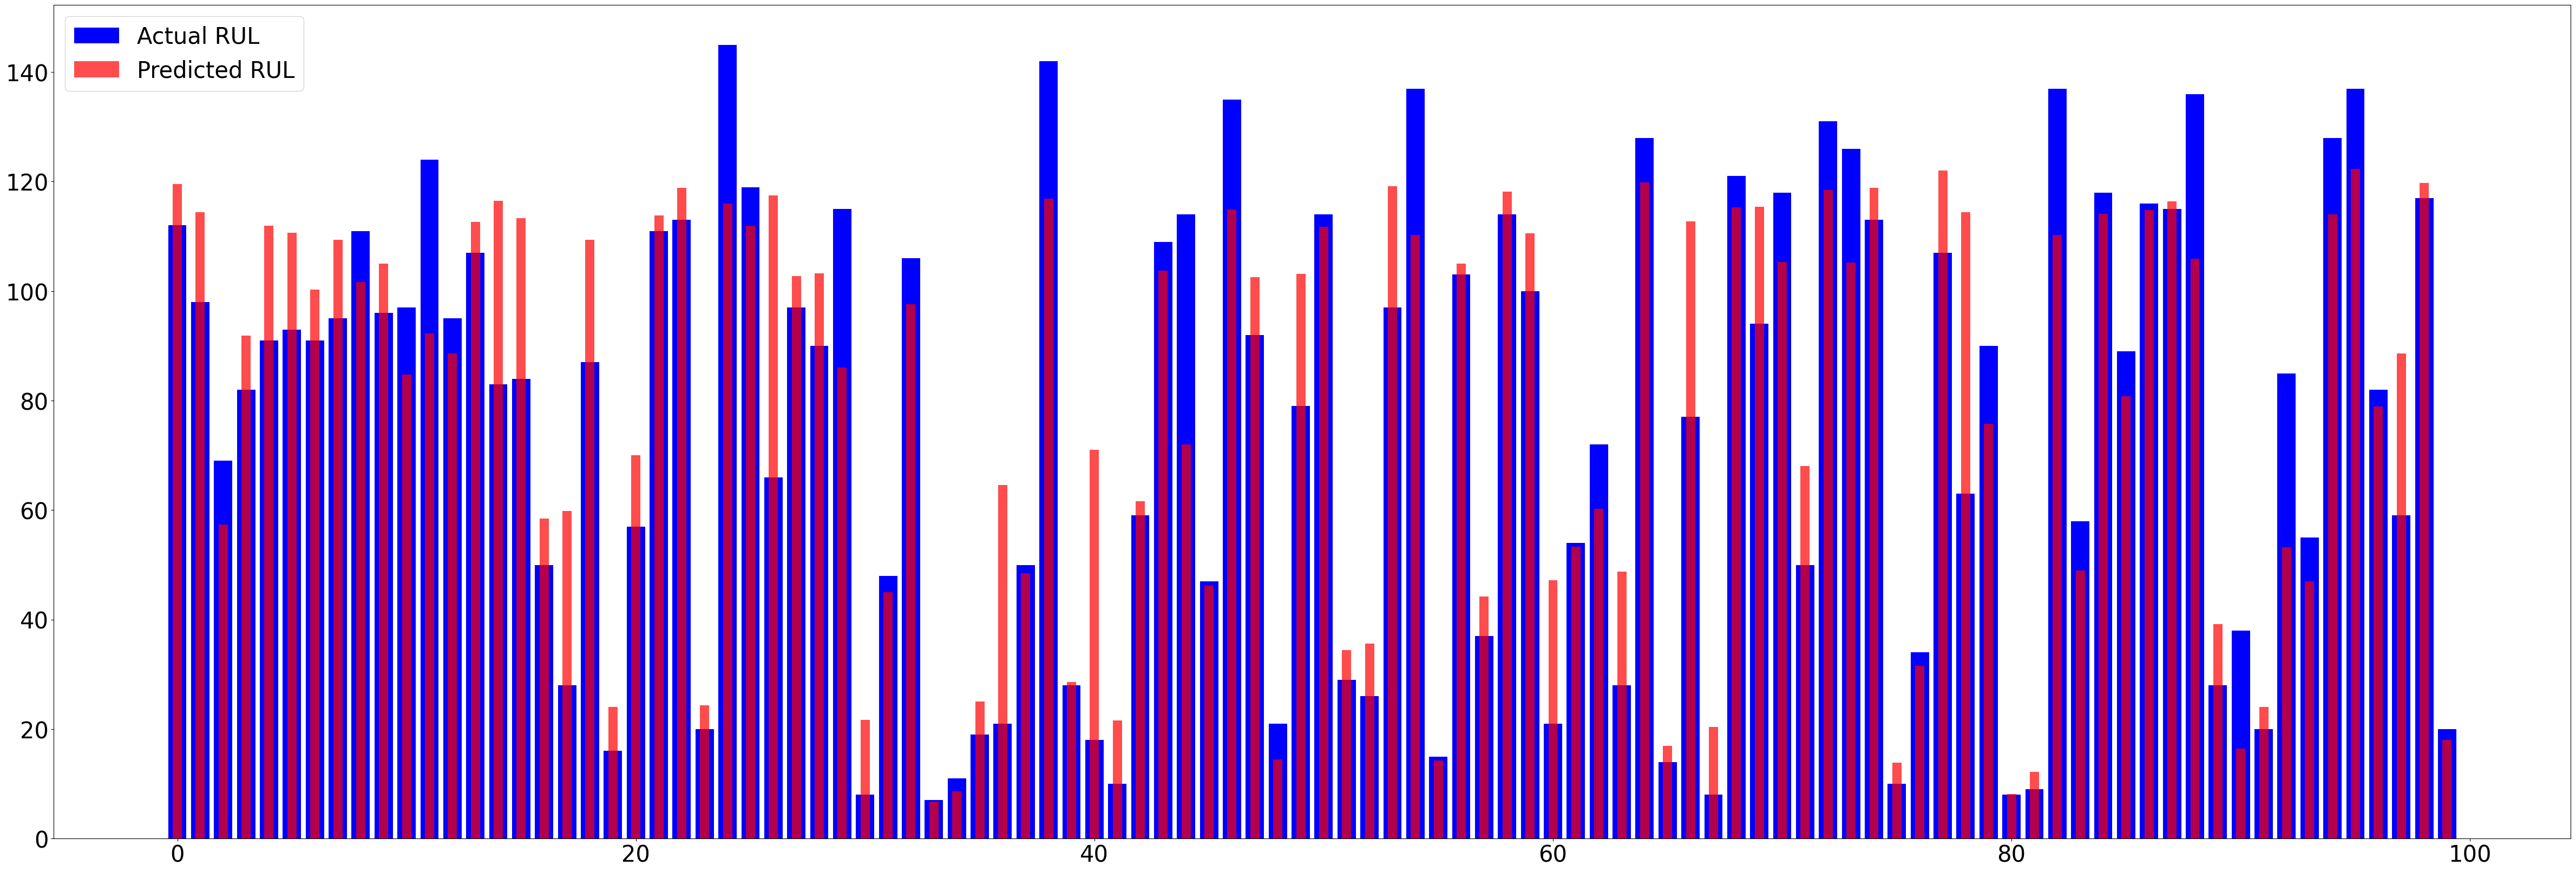

In [45]:
plot_results(y_test,y_pred_test)

In [53]:
# Определение пространства поиска параметров
param_space = {
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 5),
}

# Создание регрессора XGBoost
xgb_tuned = xgboost.XGBRegressor(random_state=42)

# Создание экземпляра поиска оптимальных параметров методом байесовской оптимизации
bayes_search = BayesSearchCV(estimator=xgb_tuned, search_spaces=param_space, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Выполнение байесовской оптимизации
bayes_search.fit(X_train_scaled, y_train_clipped)

# Получение лучших параметров
best_params = bayes_search.best_params_
print("Лучшие параметры:", best_params)

# Использование лучшей модели
best_xgb = bayes_search.best_estimator_

# Прогнозирование и оценка
y_pred_train = best_xgb.predict(X_train_scaled)
RMSE_train, R2_train = evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = best_xgb.predict(X_test_scaled)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)


Лучшие параметры: OrderedDict([('colsample_bytree', 0.7011879954524076), ('gamma', 4), ('learning_rate', 0.037000013363904315), ('max_depth', 6), ('n_estimators', 142), ('subsample', 0.7758333753763552)])
train set RMSE:16.213152916803274, R2:0.8486327535689445
test set RMSE:17.836447485491533, R2:0.8157713478176365
Лучшие параметры: OrderedDict([('colsample_bytree', 0.7011879954524076), ('gamma', 4), ('learning_rate', 0.037000013363904315), ('max_depth', 6), ('n_estimators', 142), ('subsample', 0.7758333753763552)])
train set RMSE:16.213152916803274, R2:0.8486327535689445
test set RMSE:17.836447485491533, R2:0.8157713478176365


In [59]:
## XGBoost Tuned
# Обучаем модель
xgb_tuned = xgboost.XGBRegressor(colsample_bytree=0.7011879954524076, gamma=4, learning_rate=0.037000013363904315, max_depth=6, n_estimators=142, subsample=0.7758333753763552, random_state=42)
xgb_tuned.fit(X_train_scaled, y_train_clipped)

# Прогноз и оценка
y_pred_train = xgb_tuned.predict(X_train_scaled)
RMSE_train, R2_train = evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = xgb_tuned.predict(X_test_scaled)
RMSE_test, R2_test = evaluate(y_test, y_pred_test)

train set RMSE:16.213152916803274, R2:0.8486327535689445
test set RMSE:17.836447485491533, R2:0.8157713478176365


In [60]:
Results=pd.concat([Results, pd.DataFrame({'Model':['XGB_Tuned'],'RMSE-Train':[RMSE_train],'R2-Train':[R2_train],'RMSE-Test':[RMSE_test],'R2-Test':[R2_test]})], ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,44.668192,0.579449,31.952633,0.408774
1,LR_Clipped,21.491019,0.734043,21.900213,0.722261
2,SVR,18.597971,0.800828,19.253599,0.785333
3,RF,6.763988,0.973655,17.882269,0.814824
4,XGB,16.990404,0.833772,18.417692,0.803569
5,RF_Tuned,15.426868,0.862958,17.846902,0.815555
6,XGB_Tuned,16.213153,0.848633,17.836447,0.815771


### Заключение

1. Были применены различные типы моделей машинного обучения и оценена их производительность.
2. Лучшие результаты мы получаем с помощью моделей XGBoost и Random Forest. Однако Random Forest слишком переобучен.
3. После оптимизации гиперпараметров моделей, Random Forest и XGBoost показывают примерно одинаковую производительность.